# Import libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Upload data

In [11]:
df_txn = pd.read_parquet('../df_transaction.pa')
df_train   = pd.read_parquet('../train.pa')

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   client_num  70000 non-null  int64
 1   target      70000 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


In [17]:
df_txn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13508155 entries, 0 to 13508154
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   client_num     int64         
 1   date_time      datetime64[us]
 2   mcc_code       object        
 3   merchant_name  object        
 4   amount         int64         
dtypes: datetime64[us](1), int64(2), object(2)
memory usage: 515.3+ MB


In [15]:
test_clients = (
    df_txn.loc[~df_txn.client_num.isin(df_train.client_num), "client_num"]
    .unique()
)
test_clients

array([     0,     10,     11, ..., 109130, 109137, 109140],
      shape=(39143,))

# EDA

Для начала посмотрим на общую статистиску по транзакциям из обучащей выборки

In [32]:
df_txn_train = df_txn.copy()
df_txn_train = df_txn_train.loc[~df_txn_train.client_num.isin(test_clients)]
df_txn_train.describe() # анализируем обучающую выборку

,client_num,date_time,amount
count,8.679725e+06,8679725,8.679725e+06
mean,3.870308e+04,2024-08-16 14:10:40.342980,2.370734e+03
min,1.000000e+00,2024-07-01 00:00:00,0.000000e+00
25%,1.537000e+04,2024-07-24 15:26:00,1.240000e+02
50%,3.401200e+04,2024-08-16 20:20:00,3.150000e+02
75%,5.799000e+04,2024-09-08 14:16:00,8.200000e+02
max,1.091420e+05,2024-10-01 00:00:00,8.680000e+06
std,2.738887e+04,NaN,2.399349e+04


Данные содержат транзакции с начала июля 2024 года по начало октября 2024. Минимальная транзакция равна 0, стоит ее просмотреть, возможно это выброс, также максимальная транзакция была на сумму свыше 8.5 млн у.е., необходимо так просмотреть mcc-код данный транзакции. В среднем за 3 месяца прошли транзакции прмиерно на сумму 23.5 тыс. у.е. (вероятно среднее завышено из-за одной транзакции в 8.6 млн у.е.)

In [33]:
df_txn_train.loc[df_txn_train['amount'] > 8.6e+06]

,client_num,date_time,mcc_code,merchant_name,amount
3309738,15167,2024-09-16 20:06:00,5511,07568a5fe726092363fd4ea402b1bbb640dfd2b32e9454...,8680000


Клиент совершил транзакцию с кодом 5511, что означает "Легковой и грузовой транспорт - продажа, сервис, ремонт, запчасти и лизинг". Посмотрим на ящик с усами по данному атрибуту (amount).

Text(0.5, 1.02, 'Box-plot over "amount"')

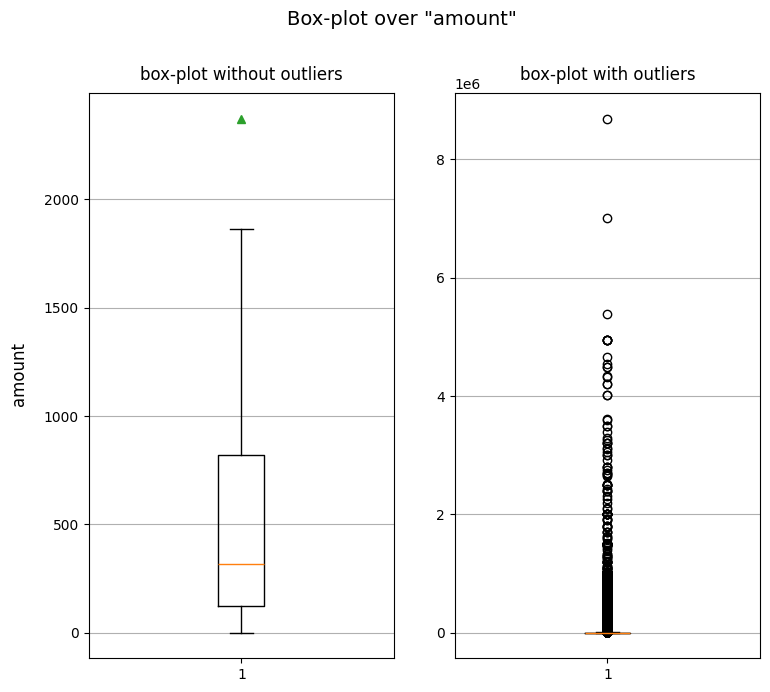

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(8,7))

axs[0].boxplot(df_txn_train['amount'], showfliers=False, showmeans=True)
axs[0].set_title('box-plot without outliers', pad=10)
axs[0].grid(axis='y')

axs[1].boxplot(df_txn_train['amount'])
axs[1].set_title('box-plot with outliers', pad=10)
axs[1].grid(axis='y')

fig.text(0.01, 0.5, 'amount', 
         va='center', rotation='vertical', fontsize=12)

plt.tight_layout(pad=3.0) 
fig.suptitle('Box-plot over "amount"', y=1.02, fontsize=14)

Из графика "ящик с усами" видно, что основная доля сумм транзакций приходится до 1750 у.е.
Транзакцию в 8.6 млн у.е. будем считать выбросами, а также все, что выше 95 перцентиля

Для анализа не только количественных атрибутов, воспользуемся интепретацией mcc кодов
https://mcc-codes.ru/code / https://mcc-cod.ru/codes/

In [72]:
print(f"Всего уникальных mcc кодов за 3 месяца - {df_txn_train['mcc_code'].nunique()}")

Всего уникальных mcc кодов за 3 месяца - 315


In [69]:
df_txn_train['mcc_code'].value_counts(normalize=True).sort_values(ascending=False)[:10] * 100

mcc_code
5411    29.645824
5499    11.292063
5814    10.628240
4131     5.420033
3990     3.982258
5541     2.915484
5912     2.543882
5921     2.470827
5812     2.202697
6011     2.156336
Name: proportion, dtype: float64

За 3 месяца преобладали транзакции с кодами 5411, 5499 и 5814, им соотвествуют "Продуктовые магазины, супермаркеты", "Различные продовольственные магазины - рынки, магазины со спец. ассортиментом..." и "Рестораны быстрого обслуживания".

Транзакции с кодом 4131 - "Автобусные линии, туристические автобусы" заняли ~5.5%, а 3990 относится к "экосистема Яндекса".

 Остальные категории менее 4-5%.

Проверим, на сколько сбалансированы классы

In [27]:
df_train['target'].value_counts(normalize=True) * 100

target
1    25.742857
0    21.558571
2    14.104286
4    11.477143
3    11.410000
5     7.867143
6     7.840000
Name: proportion, dtype: float64

In [ ]:
df_train['client_num']

Датасет несбалансирован, необходимо в среднем по 14% на каждый класс. В предосталевнных данных преварилируют классы 0, 1, а классы 6 и 5 имеют низкую долю. Однако нас в основном интересуют клиенты относящиес к классам от 0 до 2, они имеют больший вес при расчете метрики

Посмотрим на распределение средних трат в месяц в разрезе групп клиентов (от 0 до 6)

In [114]:
df_train_merged = df_txn_train.merge(df_train, how='inner', on='client_num')

In [117]:
df_train_merged['month'] = df_train_merged['date_time'].dt.month
df_train_agg = df_train_merged.groupby(by=['client_num', 'target']).agg(
    mean_amount=('amount', 'mean')
).groupby('target')['mean_amount'].apply(list)
# df_train_agg.head(20)

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_67242/2364641745.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_train_agg.values, labels=df_train_agg.index, showfliers=False, showmeans=True)


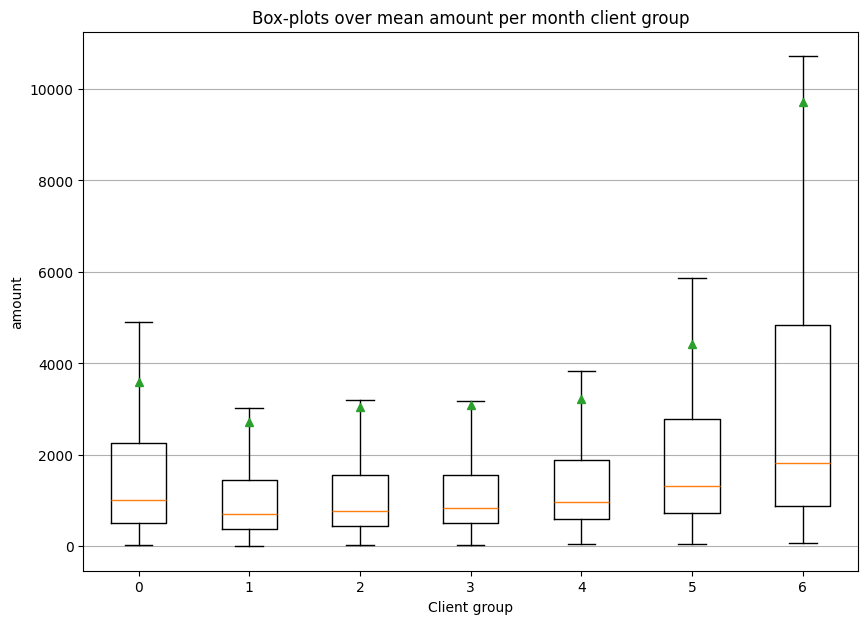

In [119]:
plt.figure(figsize=(10,7))
plt.boxplot(df_train_agg.values, labels=df_train_agg.index, showfliers=False, showmeans=True)
plt.title('Box-plots over mean amount per month client group')
plt.ylabel('amount')
plt.xlabel('Client group')
plt.grid(axis='y')

Группа 5 и 6 довольно отчетливо выделеются на фоне других, а группы с 1 по 4 очень похожи друг на жруга по телам ящиков, медианам и средним значениям

Необходимо выделить явный атрибут, который помогал бы модели различать между собой классы, хотя бы не путать 0 класс с 4 и 5, ткк как они похожи друг на друга.

# Feature engineering

In [23]:
# добавить кол-во транзакций за прошлый месяц
# сумма за прошлый месяц потраченная 
# баланс к концу прошлого месяца (считаем 28-30 число)
# средние траты
# отношение пополнений к тратам (в основном тратит или пополняет)
# кластеризовать клиентам по суммам трат? (гипотеза, что с большими тратами менее вероятно оставят нулевйо баланс)
# количество mcc-кодов определенной категории (подумать какие интересуют нас больше всего, возможно посмотреть на тех, у кого баланс около нуля, какие у них частые mcc коды)
# баланс за последнюю неделю

# Metric

In [ ]:
# Веса по классам
class_weights = {
    0: 1.00,
    1: 0.72,
    2: 0.52,
    3: 0.37,
    4: 0.27,
    5: 0.19,
    6: 0.14,
    7: 0.1
}

def wmae(y_true, y_pred, weights_map):
    weights = np.array([weights_map.get(y, 0.0) for y in y_true])
    abs_errors = np.abs(y_true - y_pred)
    return np.sum(weights * abs_errors) / np.sum(weights)

# wmae_score = wmae(y_test, y_pred, class_weights)
# print("WMAE:", wmae_score)

# Models

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=23)

## Logistic regression

In [ ]:
log_reg = LogisticRegression(penalty='elasticnet', class_weight=class_weights, max_iter=150)



## Catboost

# SHAP values